In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import math
import numpy.linalg as la
scaling=False

In [2]:
#Fashion mnist
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import model_selection
from sklearn import linear_model, ensemble, tree, neighbors, svm
from mnist.loader import MNIST

In [3]:
print("Fetching Fashion-Mnist")
print("=========================")
mndata = MNIST('../fashion-mnist/data/fashion') #added path extension for new file structure
train, train_labels = mndata.load_training()
test, test_labels = mndata.load_testing()
data = np.array(np.vstack([train, test]), dtype=np.float64) / 255.0
target = np.hstack([train_labels, test_labels])
classes = [
    'T-shirt/top',
    'Trouser', 
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']
print("Fashion-Mnist loaded")
print ("=========================")

Fetching Fashion-Mnist
Fashion-Mnist loaded


## Computing Orthogonal basis of Normal form 

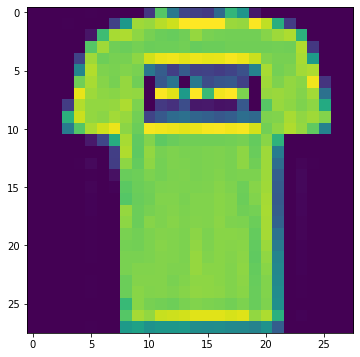

In [4]:
l=np.reshape(data[1],(28,28))
fig = plt.figure( figsize=(8, 6))
plt.imshow(l, cmap='viridis')
plt.show()

U_normal,S,Vt=la.svd(l)

In [5]:
def rotate(theta,image):
    
    theta=math.radians(theta)                               #converting degrees to radians
    cosine=math.cos(theta)
    sine=math.sin(theta)
                                 
    
    # Compute augmented image dimensions
    new_height  = round(abs(image.shape[0]*cosine)+abs(image.shape[1]*sine))+1
    new_width  = round(abs(image.shape[1]*cosine)+abs(image.shape[0]*sine))+1

    #init temp matrix to be populated with individually rotated elements
    output=np.zeros((new_height,new_width))
    # Identify point of rotation in original image
    original_centre_height   = round(((image.shape[0]+1)/2)-1)    #with respect to the original image
    original_centre_width    = round(((image.shape[1]+1)/2)-1)    #with respect to the original image

    # Find the centre of the new image that will be obtained
    new_centre_height= round(((new_height+1)/2)-1)        #with respect to the new image
    new_centre_width= round(((new_width+1)/2)-1)          #with respect to the new image
    
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            #co-ordinates of pixel with respect to the centre of original image
            y=image.shape[0]-1-i-original_centre_height                   
            x=image.shape[1]-1-j-original_centre_width 

            #Applying shear Transformation                     
            new_y,new_x=shear(theta,x,y)
            #Adjust coordinates to be relative to the new center after rotation
            new_y=new_centre_height-new_y
            new_x=new_centre_width-new_x

            output[new_y,new_x]=image[i,j]                          #writing the pixels to the new destination in the output image
    
    #trim output: 
    # iterate through matrix, if there exists an element less than tau round it down to 0
    tau=.1
    for j in range(output.shape[0]):
        for k in range(output.shape[0]):
            if output[j][k]<tau:
                output[j][k]=np.rint(output[j][k])
                
    # identify indices of zero rows and columns and delete them from the final matrix( could be done with less lines )
    
    idx = np.argwhere(np.all(output[..., :] == 0, axis=0))
    o2 = np.delete(output, idx, axis=0)
    idy = np.argwhere(np.all(output[..., :] == 0, axis=1))
    o3= np.delete(o2, idy, axis=1)
   
    return o3           
    
    #return output

In [6]:
# A shear is used here to avoid issues with anti aliasing, method described by 
#vhttps://www.ocf.berkeley.edu/~fricke/projects/israel/paeth/rotation_by_shearing.html
def shear(angle,x,y):
    '''
    |1  -tan(𝜃/2) |  |1        0|  |1  -tan(𝜃/2) | 
    |0      1     |  |sin(𝜃)   1|  |0      1     |
    '''
    
    tangent=math.tan(angle/2)
    new_x=round(x-y*tangent)
    new_y=y
    
    new_y=round(new_x*math.sin(angle)+new_y)      #since there is no change in new_x according to the shear matrix
    new_x=round(new_x-new_y*tangent)              #since there is no change in new_y according to the shear matrix
    
    return new_y,new_x

(29, 29)


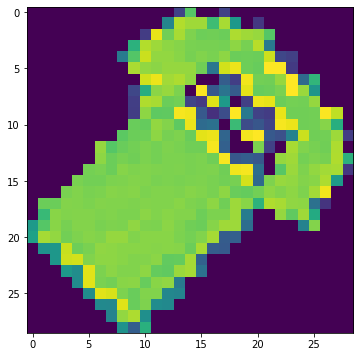

(28, 28)


In [7]:
test_sample=rotate(45,l)
print(test_sample.shape)
fig = plt.figure( figsize=(8, 6))
plt.imshow(test_sample, cmap='viridis')
plt.show()

test_sample=np.delete(test_sample,28,1)
test_sample=np.delete(test_sample,28,0)
print(np.shape(test_sample))

Checking norm between bases to begin with 

In [8]:
U_r,S_r,Vt_r=la.svd(test_sample)
print(la.norm(U_r-U_normal))

7.665594268278055


In [9]:
T=2000
learning_rate=200
momentum=0.95


Desinging the Cost  function: 
Theoretical minimization model (least squares) 

$$\mathcal{C}(\theta_k)=\text{argmin}_{\theta\in SO(2)}||SVD(\tau_{\theta}A)_U-SVD(\text{control})_U||_2^2$$

$$\mathcal{C}(\theta_k)=\text{argmin}_{\theta\in [0,2\pi]}||U_{\tau_{\theta}A}-X||_2^2$$


$$\nabla \mathcal{C}(\theta_k)=U_{\tau_{\theta}A}^T(U_{\tau_{\theta}A}-U_{\text{control}})$$

$$\nabla \mathcal{C}(\theta_k)=\frac{\partial C}{\partial U_{\tau_{\theta}A}}\frac{\partial U_{\tau_{\theta}A}}{\partial \tau_{\theta}A}\frac{\partial \tau_{\theta}A}{\partial \theta}$$


Using gradient descent with step μ>0,

$$\theta_{k+1}=\theta_k-\mu\nabla \mathcal{C}(\theta_k)$$

$$\theta_{k+1}=\theta_k-\mu(U_{\tau_{\theta}A}^TU_{\tau_{\theta}A}-U_{\tau_{\theta}A}^TU_{\text{control}})$$

$$\theta_{k+1}=\theta_k-\mu U_{\tau_{\theta}A}^TU_{\tau_{\theta}A}+\mu U_{\tau_{\theta}A}^TU_{\text{control}}$$


$$\theta_{k+1}=(\mathbb{I}_n-\mu U_{\tau_{\theta}A}^TU_{\tau_{\theta}A})\theta_k+\mu(U_{\tau_{\theta}A}^TU_{\text{control}})$$

$$\theta_k=(\mathbb{I}_n-\mu U_{\tau_{\theta}A}^TU_{\tau_{\theta}A})\theta_0+\mu\sum_{l=0}^{k-1}(\mathbb{I}_n
- \mu U_{\tau_{\theta}A}^TU_{\tau_{\theta}A})^l(U_{\tau_{\theta}A}^TU_{\text{control}})$$

It seems like we need to find some function to discuss this problem so that we can find the derviative to use grad descent on. 

In [10]:
cur_x = 3 # The algorithm starts at x=3
rate = 0.01 # Learning rate
precision = 0.000001 #This tells us when to stop the algorithm
previous_step_size = 1 #
max_iters = 10000 # maximum number of iterations
iters = 0 #iteration counter
df = lambda x: 2*(x+5) #Gradient of our function

In [11]:
while previous_step_size > precision and iters < max_iters:
    prev_x = cur_x #Store current x value in prev_x
    cur_x = cur_x - rate * df(prev_x) #Grad descent
    previous_step_size = abs(cur_x - prev_x) #Change in x
    iters = iters+1 #iteration count
    print("Iteration",iters,"\nX value is",cur_x) #Print iterations
    
print("The local minimum occurs at", cur_x)

Iteration 1 
X value is 2.84
Iteration 2 
X value is 2.6832
Iteration 3 
X value is 2.529536
Iteration 4 
X value is 2.37894528
Iteration 5 
X value is 2.2313663744
Iteration 6 
X value is 2.0867390469119997
Iteration 7 
X value is 1.9450042659737599
Iteration 8 
X value is 1.8061041806542846
Iteration 9 
X value is 1.669982097041199
Iteration 10 
X value is 1.5365824551003748
Iteration 11 
X value is 1.4058508059983674
Iteration 12 
X value is 1.2777337898784
Iteration 13 
X value is 1.152179114080832
Iteration 14 
X value is 1.0291355317992152
Iteration 15 
X value is 0.9085528211632309
Iteration 16 
X value is 0.7903817647399662
Iteration 17 
X value is 0.6745741294451669
Iteration 18 
X value is 0.5610826468562635
Iteration 19 
X value is 0.44986099391913825
Iteration 20 
X value is 0.3408637740407555
Iteration 21 
X value is 0.23404649855994042
Iteration 22 
X value is 0.1293655685887416
Iteration 23 
X value is 0.026778257216966764
Iteration 24 
X value is -0.07375730792737258
It

X value is -4.999927875384625
Iteration 576 
X value is -4.999929317876933
Iteration 577 
X value is -4.999930731519394
Iteration 578 
X value is -4.999932116889006
Iteration 579 
X value is -4.999933474551226
Iteration 580 
X value is -4.999934805060202
Iteration 581 
X value is -4.999936108958998
Iteration 582 
X value is -4.999937386779818
Iteration 583 
X value is -4.999938639044221
Iteration 584 
X value is -4.999939866263337
Iteration 585 
X value is -4.99994106893807
Iteration 586 
X value is -4.999942247559309
Iteration 587 
X value is -4.999943402608123
Iteration 588 
X value is -4.9999445345559606
Iteration 589 
X value is -4.999945643864842
Iteration 590 
X value is -4.999946730987545
Iteration 591 
X value is -4.999947796367794
Iteration 592 
X value is -4.999948840440438
Iteration 593 
X value is -4.999949863631629
Iteration 594 
X value is -4.999950866358997
Iteration 595 
X value is -4.9999518490318176
The local minimum occurs at -4.9999518490318176


After further work it appears this description of the loss function is incorrect, a different approach has been considered after consultation.